In [15]:
import pandas as pd
import rasterio
from rasterio.transform import rowcol
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Step 1: Load Data**

In [4]:
# Load airport and road network data
airports = pd.read_csv('data/indian_airports.csv').drop('Unnamed: 0', axis=1)  # name, lat, lon
Center = pd.read_csv('data/Center.csv')
East = pd.read_csv('data/East.csv')
West = pd.read_csv('data/West.csv')
South = pd.read_csv('data/South.csv')
NorthWest = pd.read_csv('data/NorthWest.csv')
NorthEast = pd.read_csv('data/NorthEast.csv')

# Combine road network data
RoadNetwork = pd.concat([Center, East, West, South, NorthEast, NorthWest])  # Columns X (longitude), Y (latitude)

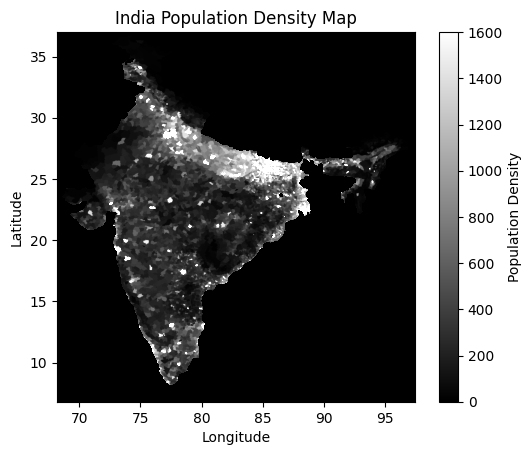

In [3]:
# Load population density raster
with rasterio.open('data/India_PD.tif') as src:
    band1 = src.read(1)  # Population density data
    crs = src.crs
    transform = src.transform
    bounds = src.bounds

    # Visualize population density raster
    plt.imshow(band1, cmap='gray', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], vmin=0, vmax=1600)
    plt.title("India Population Density Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Population Density")
    plt.show()

### **Step 2: Map Road Network to Raster Grid**

In [5]:
# Function to map lat/lon points to raster grid coordinates
def map_to_raster(x, y, transform):
    return rowcol(transform, x, y)

# Get grid coordinates for the road network
RoadNetwork['rowcol'] = RoadNetwork.apply(lambda row: map_to_raster(row['X'], row['Y'], transform), axis=1)

### **Step 3: Prepare GeoDataFrames for Visualization**

In [6]:
# Create GeoDataFrame for roads
road_gdf = gpd.GeoDataFrame(RoadNetwork, 
                            geometry=gpd.points_from_xy(RoadNetwork['X'], RoadNetwork['Y']), 
                            crs=crs)

# Create GeoDataFrame for airports
airport_gdf = gpd.GeoDataFrame(airports, 
                               geometry=gpd.points_from_xy(airports['lon'], airports['lat']), 
                               crs=crs)

### **Step 4: Overlay and Visualize Data**

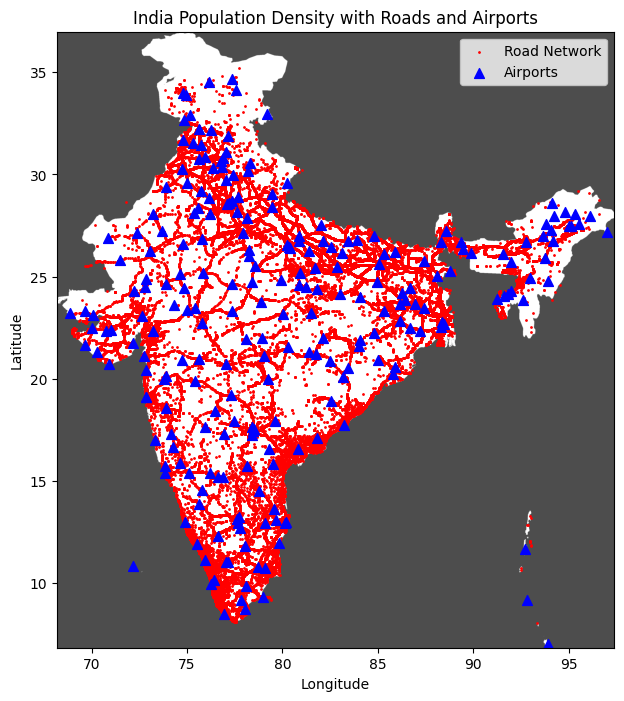

In [7]:
# Plot population density, road network, and airports
fig, ax = plt.subplots(figsize=(12, 8))
plt.imshow(band1, cmap='gray', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], alpha=0.7)

# Add road network points
road_gdf.plot(ax=ax, marker='o', color='red', markersize=1, label='Road Network')

# Add airport points
airport_gdf.plot(ax=ax, marker='^', color='blue', markersize=50, label='Airports')

# Add legend and labels
plt.legend()
plt.title("India Population Density with Roads and Airports")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### **Step 5: Calculate Population Density at Road and Airport Points**

In [7]:
# Function to sample population density at given lat/lon
def sample_population_density(lat, lon, src, transform):
    row, col = map_to_raster(lon, lat, transform)
    try:
        return band1[row, col] if 0 <= row < band1.shape[0] and 0 <= col < band1.shape[1] else 0
    except IndexError:
        return 0

# Add population density to roads
RoadNetwork['population_density'] = RoadNetwork.apply(
    lambda row: sample_population_density(row['Y'], row['X'], src, transform), axis=1
)

# Add population density to airports
airports['population_density'] = airports.apply(
    lambda row: sample_population_density(row['lat'], row['lon'], src, transform), axis=1
)

RoadNetwork['population_density'] = RoadNetwork['population_density'].clip(lower=0, upper=89165.13)

# **Step 6: Save Outputs for Simulation**
# Save processed road network and airport data
RoadNetwork.to_csv('derived_data/processed_road_network.csv', index=False)
airports.to_csv('derived_data/processed_airports.csv', index=False)

print("Processed road network and airport data saved for simulation!")

Processed road network and airport data saved for simulation!


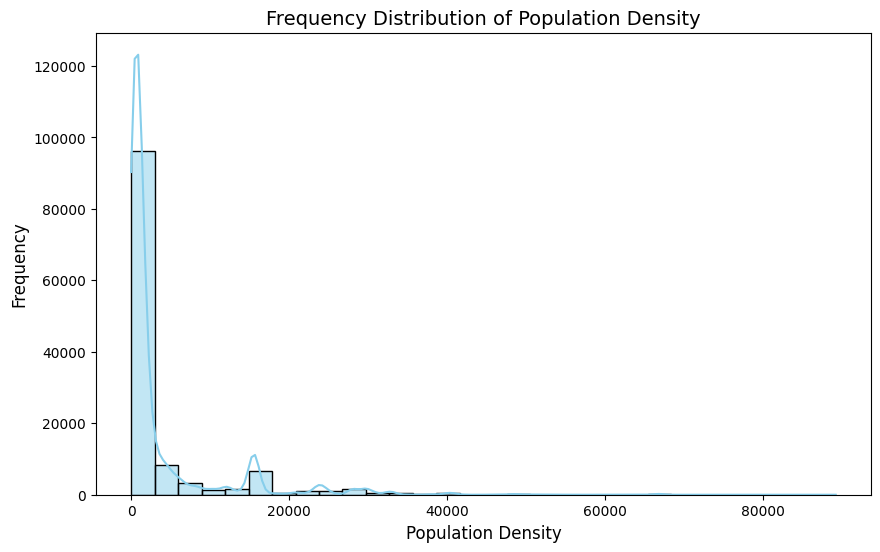

In [9]:
plt.figure(figsize=(10, 6))

# Plotting the frequency distribution
sns.histplot(RoadNetwork['population_density'], bins=30, kde=True, color='skyblue')

# Adding labels and title
plt.title('Frequency Distribution of Population Density', fontsize=14)
plt.xlabel('Population Density', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

### **Step 6: Voxel Grid Downsampling**

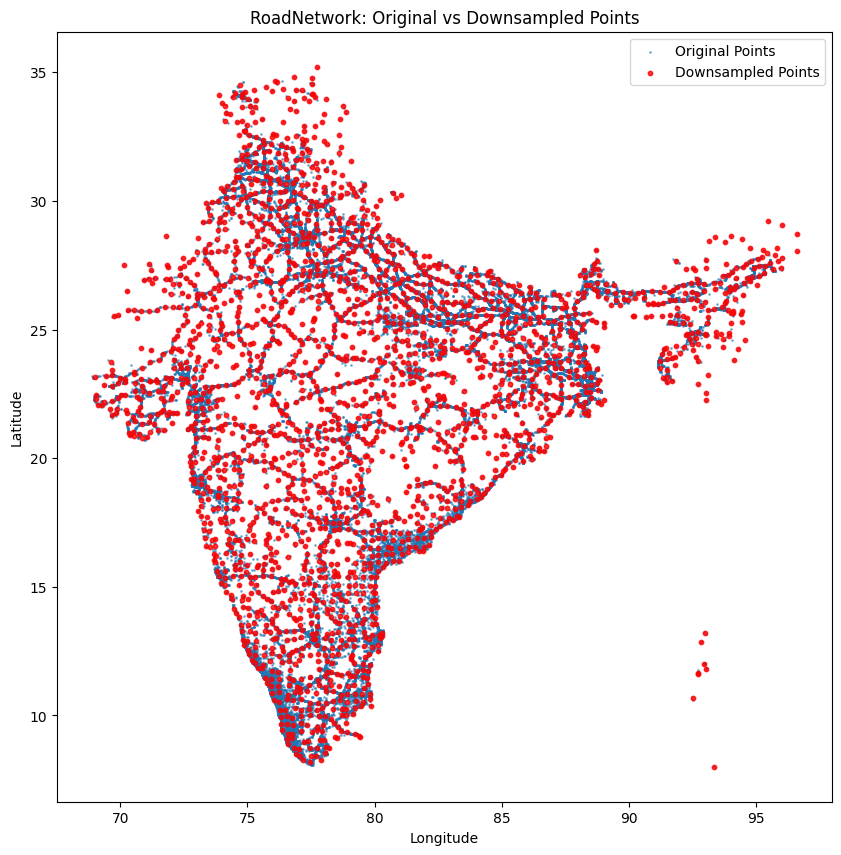

Downsampled RoadNetwork saved!


In [14]:
RoadNetwork = pd.read_csv('derived_data/processed_road_network.csv')  # Assuming 'X', 'Y', and 'population_density' columns
x_coords = RoadNetwork['X'].values  # Longitude
y_coords = RoadNetwork['Y'].values  # Latitude
population_density = RoadNetwork['population_density'].values

# **Step 1: Define Grid Parameters**
grid_size = 0.3  # Size of each grid cell in degrees (adjust based on required resolution)

# Calculate grid boundaries
x_min, x_max = x_coords.min(), x_coords.max()
y_min, y_max = y_coords.min(), y_coords.max()

# Create grid indices for each point
x_indices = np.floor((x_coords - x_min) / grid_size).astype(int)
y_indices = np.floor((y_coords - y_min) / grid_size).astype(int)

# Combine indices to identify unique grid cells
grid_indices = pd.DataFrame({'x_index': x_indices, 'y_index': y_indices, 
                             'X': x_coords, 'Y': y_coords, 'population_density': population_density})

# **Step 2: Aggregate Points in Each Grid Cell**
# For each cell, calculate the centroid and sum the population density
downsampled = grid_indices.groupby(['x_index', 'y_index']).agg({
    'X': 'mean',  # Use mean longitude as the centroid
    'Y': 'mean',  # Use mean latitude as the centroid
    'population_density': 'sum'  # Aggregate population density
}).reset_index()

# **Step 3: Visualize Downsampled Points**
plt.figure(figsize=(10, 10))
plt.scatter(RoadNetwork['X'], RoadNetwork['Y'], s=1, label='Original Points', alpha=0.5)
plt.scatter(downsampled['X'], downsampled['Y'], s=10, c='red', label='Downsampled Points', alpha=0.8)
plt.title("RoadNetwork: Original vs Downsampled Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# **Step 6: Save Downsampled RoadNetwork**
downsampled.to_csv('derived_data/downsampled_road_network.csv', index=False)
print("Downsampled RoadNetwork saved!")
